## Transfer Learning

전이학습(Transfer Learning)은 특정 상황에서 모델을 학습하면서 얻은 지식을 다른 상황에 활용하는 학습방법.

1. 데이터 부족 문제를 어느정도는 해결
2. 학습에 걸리는 시간을 단축할 수 있음
3. 시뮬레이션에서 학습한 모델을 현실에 적용할 수 있게 해준다 (ex.자율주행자동차)

In [1]:
#ResNet50 pretraind된 모델 불러오기(imagenet으로 훈련)

import torchvision.models as models
resnet = models.resnet50(pretrained=True)

In [2]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [4]:
print(list(resnet.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
#Transfer Learning
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, num_category):
        super(ResNet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:-1]) #특성 추출기만 사용하므로
        self.layer1 = nn.Sequential(nn.Linear(2048, 500), nn.BatchNorm1d(500), nn.ReLU(),
                                     nn.Linear(500, num_category))
    
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(batch_size, -1)
        out = self.layer1(out)
        return out

model = ResNet(10)
model.eval()

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [6]:
#model의 layer0부분은 학습하지 않음
for param in model.layer0.parameters():
    param.requires_grad = False

#model의 layer1부분은 학습함.
for param in model.layer1.parameters():
    param.requires_grad = True

## Style transfer(feat. Transfer Learning)

전이학습의 대표적인 활용사례임. 

Style Transfer에서 활용되는 모델은 주로, 이미지넷에 pretrained된 모델을 쓴다. 그 이유는 필터의 범용성에 있다. pretrained 된 모델의 필터에는 처음에는 이미지의 가로선, 대각선, 색 등에 반응하는 필터도 존재하고, layer가 깊어질수록 복잡하고 추상적인 이미지의 패턴에 반응할 수 있는 필터도 존재한다. 이러한 필터는 단순히 이미지넷에서만 제한되는 것이 아니라, '다른 이미지에 적용할 수 있는 필터'들이다.

Style Transfer의 구조를 쉽게 설명하면, 어떤 이미지의 스타일을 가져와 콘텐츠가 되는 이미지에 적용한 이미지를 만들어 내는 것이다. 예를 들면 반고흐의 그림의 스타일을 유럽의 건물들의 사진(콘텐츠)에 적용한 이미지를 만들어 내는 것이다. 논문에서 정의한 스타일과 콘텐츠의 정의를 살펴보면, 먼저 스타일은 correlation between the diffrent filter responses라고 정의한다. 즉 서로 다른 필터를 통과한 활성화 텐서들 사이의 상관관계라고 해석할 수 있다. 이는 그람 행렬을 통해 벡터사이의 내적으로 표현할 수 있다. 콘텐츠는 feature responses in higher layers of the network라고 정의한다. 즉 깊은 layer의 활성화 맵들을 가르킨다고 해석할 수 있다. Style Transfomer를 전이학습의 대표적인 활용사례라고 말하는 이유는 스타일과 콘텐츠를 가져오는 모델, 역전파를 통해 이미지를 만들기 위해 사용하는 모델 전부 pretrained된 모델을 사용하기 때문이다.

그렇다면 Style Transfer는 어떤식으로 학습할까? 먼저 손실함수를 스타일에 해당하는 loss와 콘텐츠에 대한 loss를 각각의 가중치를 곱해서 더한 값을 활용한다. 스타일 loss는 모든 layer에서 발생하는데, 이는 layer를 거듭할 수록 receptive field가 달라지기 때문이다. 즉 세밀한 영역부터 넓은 영역까지의 스타일을 학습하기 위함이다. 반면 콘텐츠 loss는 특정 layer에서만 계산되는데, 이는 콘텐츠의 형태를 잘 보존하면서, 스타일을 잘 입힐 수 있는 위치를 실험적으로 찾은 것으로 보인다. 다음으로 Optimizer는 기존 Adam, SGD와 다른 L-BFGS 를 사용한다. 이는 2차 미분을 활용한 경사하강법을 계산속도를 올리기 위해, 근사한 Optimizer이다.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [8]:
import os

content_dir = 'style_transformer_images/content/dog.jpg'
style_dir = 'style_transformer_images/style/monet.jpg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
content_layer_num = 1
image_size = 512
epoch = 5000

In [10]:
# 이미 학습된 ResNet 모델이 이미지넷으로 학습된 모델이기 때문에 이에 맞춰 정규화.

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img


# 정규화 된 상태로 연산을 진행했던 값들을 다시 더해줌.
# 또한 이미지가 0에서 1사이의 값을 가지게 해준다.
def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [11]:
#style과 content 이미지는 학습하면 안됨.
content = image_preprocess(content_dir).requires_grad_(False).to(device)
style = image_preprocess(style_dir).requires_grad_(False).to(device)
generated = content.data.clone().requires_grad_(True).to(device)

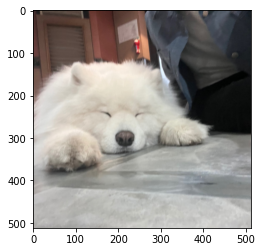

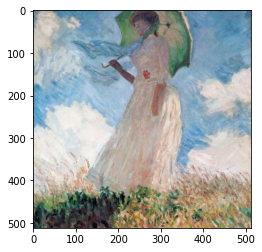

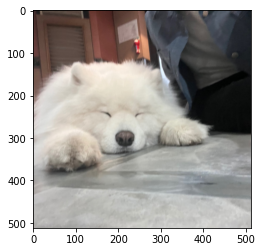

In [12]:
plt.imshow(image_postprocess(content[0]).cpu())
plt.show()
plt.imshow(image_postprocess(style[0]).cpu())
plt.show()
plt.imshow(image_postprocess(generated[0]).cpu().detach().numpy())
plt.show()

In [13]:
resnet = models.resnet50(pretrained=True).to(device)

In [14]:
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [15]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1]) #conv1
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4]) #bn1~maxpool
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5]) #layer1
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6]) #layer2
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7]) #layer3
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8]) #layer4
    
    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5


In [16]:
resnet = Resnet()

In [17]:
#모델은 학습하지 않음
for param in resnet.parameters():
    param.requires_grad = False

In [18]:
#activation map들을 그람행렬로 만드는 class
class GramMatrix(nn.Module):
    def forward(self,input):
        b,c,h,w = input.size()
        F = input.view(b,c,h*w)
        G = torch.bmm(F, F.transpose(1,2)) #torch.bmm은 배치부분에 해당하는 차원은 제외하고 행렬곱을 수행
        return G #차원은 batch*channel*channel

#input을 받아서, 그람행렬을 구하고, target과 MSEloss 계산하는 class
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [19]:
style_target = list(GramMatrix()(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
#서로다른 layer에서 뽑은 그람행렬의 크기가 다르므로, 정규화해줘야 함
style_weight = [1/n**2 for n in [64, 64, 256, 512, 1024, 2048]] 

In [20]:
#optimizer: LBFGS -> 1차 미분값들을 이용해 2차 미분값을 계산하기 때문에 클로저를 통해 1차 미분값을 전달해줘야 함.
import torch.optim as optim

optimizer = optim.LBFGS([generated])#학습하는 대상은 이미지임.

iteration = [0]
while iteration[0] < epoch:
    
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        style_loss = [GramMSELoss()(out[i], style_target[i])*style_weight[i] for i in range(len(style_target))]
        content_loss = nn.MSELoss()(out[content_layer_num], content_target)
        total_loss = sum(style_loss)*1000 + content_loss
        total_loss.backward()
        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss
    
    optimizer.step(closure)
    
        
    

tensor(642614.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(179.1085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.0430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.5269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2987, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0749, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8426, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2747, device='cuda:0', grad_fn

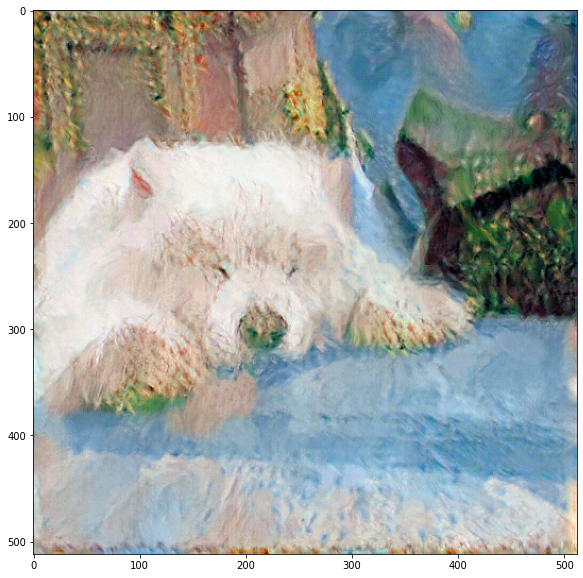

In [22]:
gen_img = image_postprocess(generated[0]).cpu().detach().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(gen_img)
plt.show()